<a href="https://colab.research.google.com/github/shreyas-jk/Employer-Review-About-Their-Organisation-Kaggle/blob/main/Employee_Review_Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle datasets download -d muhammedabdulazeem/employer-review-about-their-organization

In [ ]:
! unzip employer-review-about-their-organization.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import math
import pickle

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

! pip install pandasql
from pandasql import sqldf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [151]:
f = open('/content/results.json',)
data = json.load(f)
df = pd.DataFrame(data)
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3.0,"(Current Employee) - Ghansoli - August 30,..."
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3.0,"(Former Employee) - - August 26, 2021"
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5.0,"(Former Employee) - - August 17, 2021"
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5.0,"(Current Employee) - - August 17, 2021"
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1.0,"(Former Employee) - - August 9, 2021"


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145209 entries, 0 to 145208
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ReviewTitle     145209 non-null  object
 1   CompleteReview  145209 non-null  object
 2   URL             145209 non-null  object
 3   Rating          145209 non-null  object
 4   ReviewDetails   145209 non-null  object
dtypes: object(5)
memory usage: 5.5+ MB


In [153]:
print('--------')
display(df.ReviewTitle.unique())
display(print('Unique values: ', len(df.ReviewTitle.unique())))

print('--------')
display(df.URL.unique())
display(print('Unique values: ', len(df.URL.unique())))

print('--------')
display(df.ReviewDetails.unique())
display(print('Unique values: ', len(df.ReviewDetails.unique())))

--------


array(['Productive', 'Stressful', 'Good Company for Every employee', ...,
       'IT Services Company; Great scope for improvement.',
       'Productive, fun to work, great place to do certification and learn about SCM. Overall, a great company to start a career',
       'Great place to start the career.'], dtype=object)

Unique values:  83873


None

--------


array(['https://in.indeed.com/cmp/Reliance-Industries-Ltd/reviews',
       'https://in.indeed.com/cmp/Mphasis/reviews',
       'https://in.indeed.com/cmp/Kpmg/reviews', ...,
       'https://in.indeed.com/cmp/Tata-Consultancy-Services-(tcs)/reviews?start=14400',
       'https://in.indeed.com/cmp/Tata-Consultancy-Services-(tcs)/reviews?start=14420',
       'https://in.indeed.com/cmp/Tata-Consultancy-Services-(tcs)/reviews?start=14440'],
      dtype=object)

Unique values:  7286


None

--------


array(['(Current Employee)  -  Ghansoli  -  August 30, 2021',
       '(Former Employee)  -   -  August 26, 2021',
       '(Former Employee)  -   -  August 17, 2021', ...,
       '(Former Employee)  -   -  January 19, 2012',
       '(Former Employee)  -   -  January 7, 2012',
       '(Former Employee)  -   -  December 19, 2011'], dtype=object)

Unique values:  20719


None

**As we can see, company name is mentioned in the URL & ReviewDetails has Datetime, Employeee type and Location.**



**We will try to extract them as much as possible.**

# Extracting and Preprocessing

**Extracting Company names**

In [154]:
# Extracting Company name from URL
df['Company'] = df.URL.str.split('/')[:].str[4]

In [155]:
# Checking unique values in Company
display(df.Company.unique())
display(print('Unique values: ', len(df.Company.unique())))

array(['Reliance-Industries-Ltd', 'Mphasis', 'Kpmg', 'Yes-Bank',
       'Sutherland', 'Marriott-International,-Inc.', 'DHL', 'Jio',
       'Vodafoneziggo', 'HP', 'Maersk', 'Ride.swiggy', 'Jll', 'Alstom',
       'UnitedHealth-Group', 'Tata-Consultancy-Services-(tcs)',
       'Capgemini', 'Teleperformance', 'Cognizant-Technology-Solutions',
       'Mahindra-&-Mahindra-Ltd', 'L&T-Technology-Services-Ltd.',
       'Bharti-Airtel-Limited', 'Indeed', 'Hyatt',
       'Icici-Prudential-Life-Insurance', 'Accenture', 'Honeywell',
       'Standard-Chartered-Bank', 'Nokia', 'Apollo-Hospitals',
       'Tata-Aia-Life', 'Hdfc-Bank', 'Bosch', 'Deloitte', 'Ey',
       'Microsoft', 'Barclays', 'JPMorgan-Chase', 'Muthoot-Finance',
       'Wns-Global-Services', 'Kotak-Mahindra-Bank', 'Infosys', 'Oracle',
       "Byju's", 'Deutsche-Bank', 'Hinduja-Global-Solutions', 'Ericsson',
       'Axis-Bank', 'IBM', 'Concentrix', 'Wells-Fargo', 'Google',
       'Dell-Technologies', 'Facebook', 'Amazon.com', 'Flipkart.

Unique values:  59


None

**Extracting Datetime**

In [156]:
# Extracting Date & Time from ReviewDetails
df['Timestamp'] = df['ReviewDetails'].str.split('-', expand=True)[2]

In [157]:
# Spliting Year, Month, Day
df['Year'] = df['Timestamp'].str.split(',', expand=True)[1]
df['Month'] = df['Timestamp'].str.split(',', expand=True)[0].str.split(' ', expand=True)[2]
df['Day'] = df['Timestamp'].str.split(',', expand=True)[0].str.split(' ', expand=True)[3]

In [158]:
# Checking missing values
display(df['Day'].isnull().sum())
display(df['Month'].isnull().sum())
display(df['Year'].isnull().sum())

60

8

135

In [159]:
# Dropping missing values
df = df.dropna()

In [160]:
# Removing unecessary blank spaces
df['Year'] = df['Year'].str.replace(' ', '')

In [161]:
# Merging and adding new Datetime column
temp_date = df[['Day', 'Month', 'Year']]
df['Timestamp'] = pd.to_datetime(temp_date.astype(str).agg('-'.join, axis=1), format='%d-%B-%Y')

In [162]:
# Dropping unecessary columns
df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

In [163]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company,Timestamp
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3.0,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,2021-08-30
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3.0,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,2021-08-26
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5.0,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5.0,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1.0,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd,2021-08-09


**Extracting Type of Employee submitted the review**

In [164]:
# Extract EmployeeType from ReviewDetails
df['EmployeeType'] = df['ReviewDetails'].str.split('-', expand=True)[0]

In [165]:
# Checking Unique values
display(df.EmployeeType.unique())
display(print('Unique values: ', len(df.EmployeeType.unique())))

array(['(Current Employee)  ', '(Former Employee)  ',
       'Training   (Former Employee)  ', 'Officer   (Former Employee)  ',
       'Leader   (Current Employee)  ',
       'health care   (Current Employee)  ',
       'Good team worker   (Former Employee)  ',
       'Officer   (Current Employee)  ',
       'Sr.G.M.Engineering and projects .   (Former Employee)  ',
       'Hospitality   (Former Employee)  ',
       'Employee   (Current Employee)  ',
       'Employee   (Former Employee)  ', 'Worker   (Former Employee)  ',
       'SBI PR outbound    (Current Employee)  ',
       'PR in SBI outbound    (Current Employee)  ',
       'SBI PR    (Former Employee)  ', 'Senior   (Former Employee)  ',
       'Sbi inbound    (Current Employee)  ',
       'KOTAK CARD    (Current Employee)  ',
       'Marketing   (Current Employee)  ', 'Yes   (Current Employee)  ',
       'Kotak cardit card    (Current Employee)  ',
       'Kotak cards    (Current Employee)  ',
       'OFFICER   (Current Employee

Unique values:  180


None

In [166]:
def get_employee_type(value):
  return 'Current Employee' if 'Current' in value else 'Former Employee'

In [167]:
# Add new column EmployeeTpe
df['EmployeeType'] = df.apply(lambda row: get_employee_type(row['EmployeeType']),axis=1)

In [168]:
df.head()

,ReviewTitle,CompleteReview,URL,Rating,ReviewDetails,Company,Timestamp,EmployeeType
0,Productive,"Good company, cool workplace, work load little...",https://in.indeed.com/cmp/Reliance-Industries-...,3.0,"(Current Employee) - Ghansoli - August 30,...",Reliance-Industries-Ltd,2021-08-30,Current Employee
1,Stressful,1. Need to work on boss's whims and fancies 2....,https://in.indeed.com/cmp/Reliance-Industries-...,3.0,"(Former Employee) - - August 26, 2021",Reliance-Industries-Ltd,2021-08-26,Former Employee
2,Good Company for Every employee,"Good company for every Engineers dream, Full M...",https://in.indeed.com/cmp/Reliance-Industries-...,5.0,"(Former Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,Former Employee
3,Productive,I am just pass out bsc in chemistry Typical da...,https://in.indeed.com/cmp/Reliance-Industries-...,5.0,"(Current Employee) - - August 17, 2021",Reliance-Industries-Ltd,2021-08-17,Current Employee
4,Non productive,Not so fun at work just blame games Target pe...,https://in.indeed.com/cmp/Reliance-Industries-...,1.0,"(Former Employee) - - August 9, 2021",Reliance-Industries-Ltd,2021-08-09,Former Employee


**Extracting Location from Review Details**

In [169]:
df['Location'] = df['ReviewDetails'].str.split('-', expand=True)[1]

In [170]:
display(df.Location.unique())
display(print('Unique values: ', len(df.Location.unique())))

array(['  Ghansoli  ', '   ', '  Dahej, Gujarat  ', ...,
       '  Bhosari, pune  ', '  Siruseri/TN/India  ', '  Nerul, India  '],
      dtype=object)

Unique values:  3656


None

**Merging ReviewTitle + CompleteReview, cause not considering will be a waste.**

In [171]:
df['Review'] = df['ReviewTitle'] + ' ' + df['CompleteReview']

In [172]:
# Drop uneccsary columns
df.drop(['ReviewTitle', 'CompleteReview', 'URL', 'ReviewDetails'], axis=1, inplace=True)

In [173]:
df.Location = df.Location.str.strip()
df.Location = df.Location.str.lower()

In [174]:
sqldf("""select Location, count(*) from df group by Location order by count(*) desc limit 10""")

,Location,count(*)
0,,129941
1,india,4363
2,"bangalore urban, karnataka",989
3,hp,278
4,in,242
5,kerala,226
6,gujarat,200
7,karnataka,187
8,haryana,179
9,"airoli, navi mumbai, maharashtra",161


In [175]:
df.Location[df['Location'] == ''] = 'Unknown'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [176]:
df.Location.unique()

array(['ghansoli', 'Unknown', 'dahej, gujarat', ..., 'bhosari, pune',
       'siruseri/tn/india', 'nerul, india'], dtype=object)

**Locations are entered manually so it os inconsistent and unrealiable. We may not be able to use it until we clean it manually. My Bad**

# EDA

In [177]:
df.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Rating,Company,Timestamp,EmployeeType,Location,Review
count,145067,145067,145067,145067,145067,145067
unique,5,59,3542,2,3295,144890
top,4.0,Tata-Consultancy-Services-(tcs),2017-03-05 00:00:00,Former Employee,Unknown,good a typical day at work\r what you learned\...
freq,58094,14431,305,79388,129941,5
first,NaN,NaN,2011-08-31 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2021-09-08 00:00:00,NaN,NaN,NaN


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

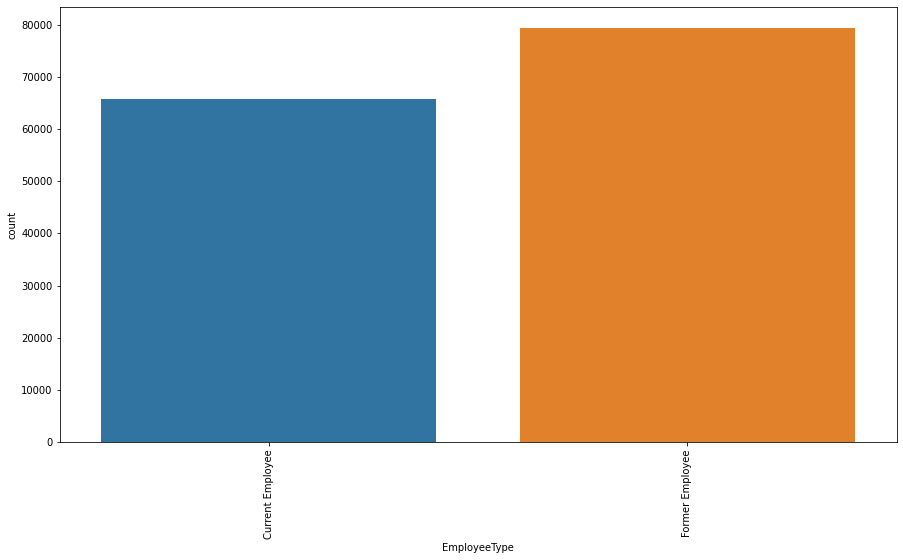

In [178]:
plt.figure(figsize = (15,8))
sns.countplot(x ='EmployeeType', data = df)
plt.xticks(rotation=90)

EmployeeType seems fairly balanced

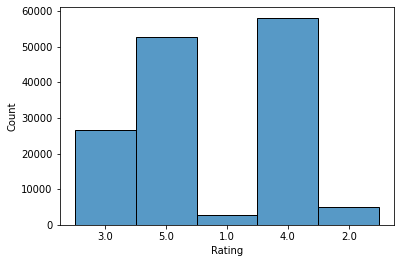

In [179]:
sns.histplot(df['Rating'])

Here we can see that the dataset is imbalance which can effect the model performance

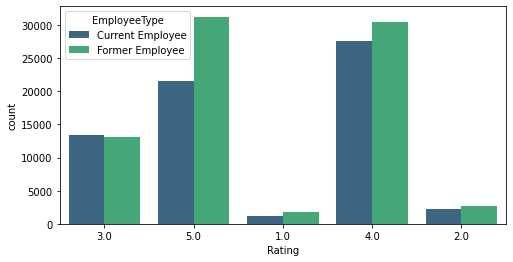

In [180]:
plt.figure(figsize=(8,4))
sns.countplot(x='Rating', hue='EmployeeType',data=df,palette='viridis')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 <a list of 59 Text major ticklabel objects>)

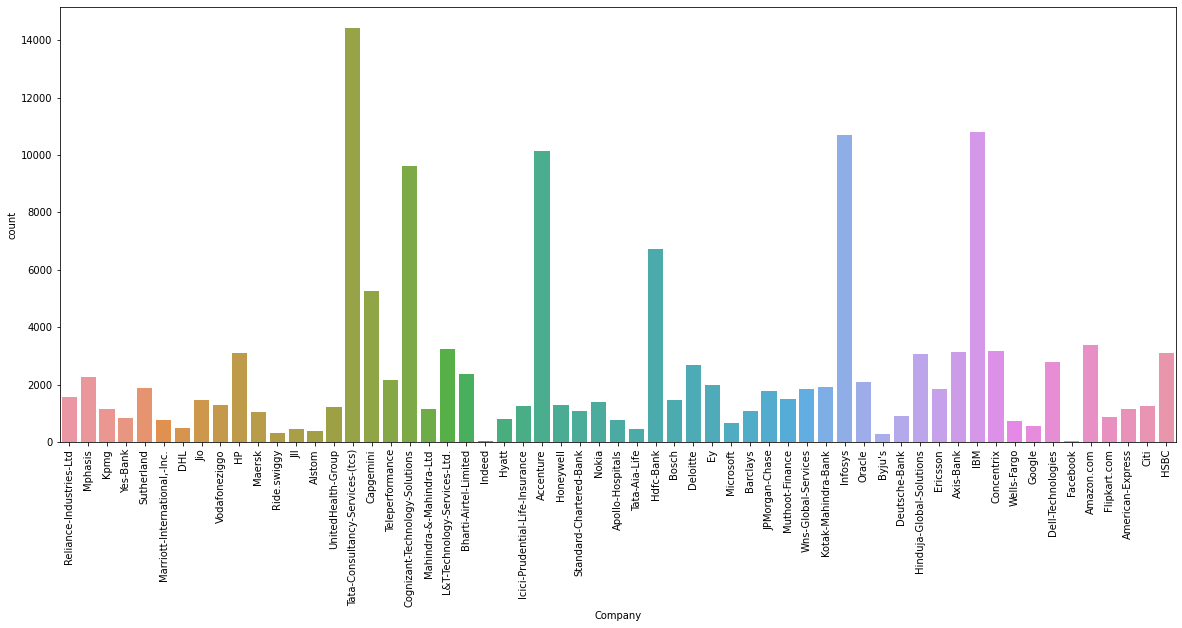

In [181]:
plt.figure(figsize = (20,8))
sns.countplot(x ='Company', data = df)
plt.xticks(rotation=90)

Large number of reviews belongs to TCS, IBM, Accenture, Infosys, HDFC


**Rating Distribution for Top 10 Companies (Review Count)**

In [182]:
dftop_10 = sqldf("""select Company, count(*) from df group by Company order by count(*) desc limit 10""")
dftop_10 = sqldf("""select * from df where Company in (select Company from dftop_10)""")

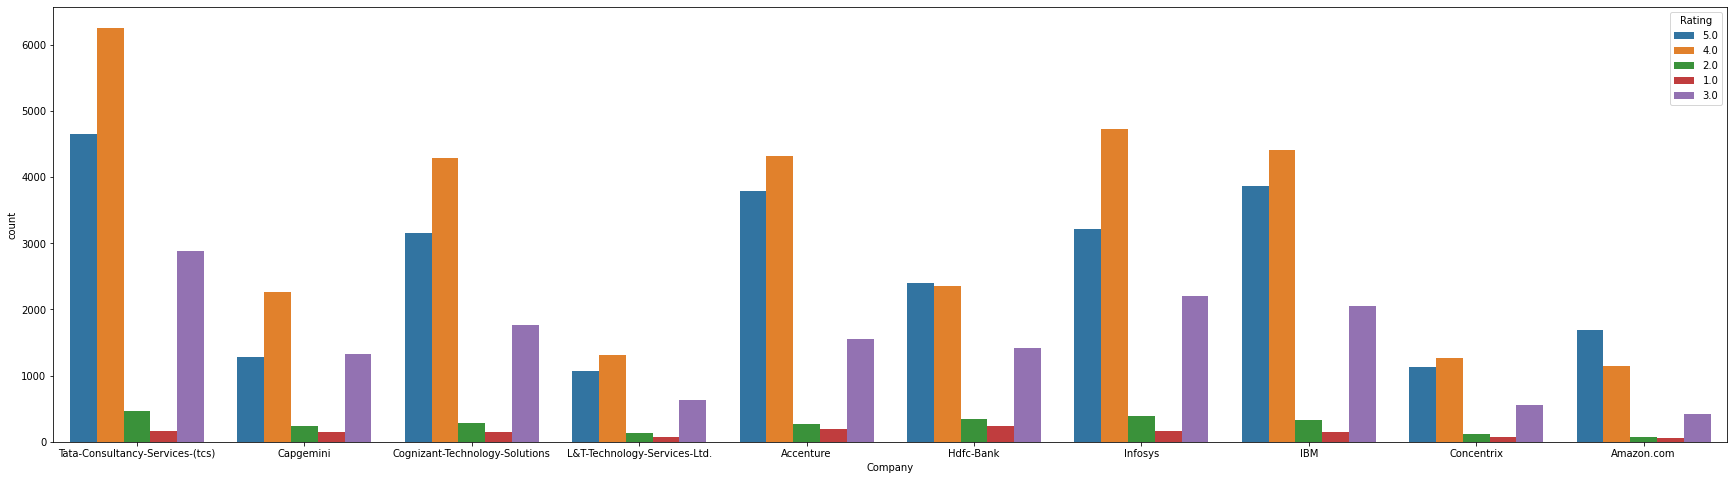

In [183]:
plt.figure(figsize = (30,8))
sns.countplot(x="Company", hue="Rating", data=dftop_10)

**Rating Distribution for Bottom 10 Companies (Review Count)**

In [184]:
dfbot_10 = sqldf("""select Company, count(*) from df group by Company order by count(*) asc limit 10""")
dfbot_10 = sqldf("""select * from df where Company in (select Company from dfbot_10)""")
dfbot_10.Rating = pd.to_numeric(dfbot_10.Rating)

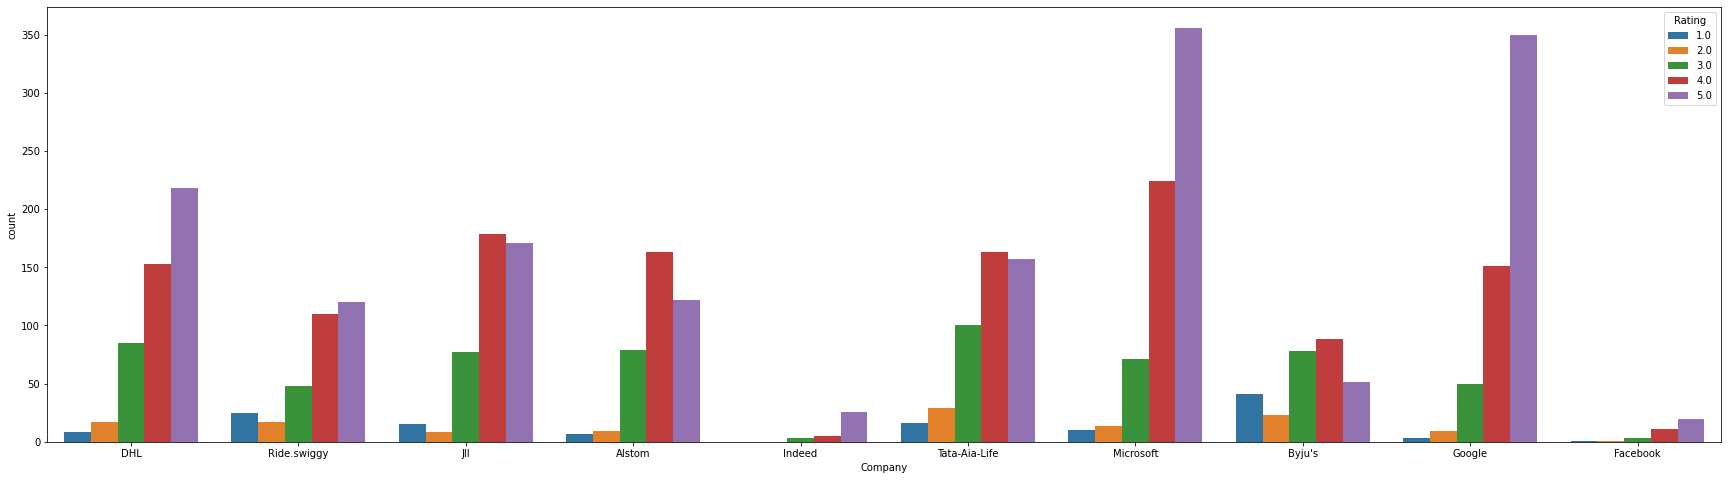

In [185]:
plt.figure(figsize = (30,8))
sns.countplot(x="Company", hue="Rating", data=dfbot_10)

**Timestamp-Rating Analysis**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `fi

<Figure size 432x288 with 0 Axes>

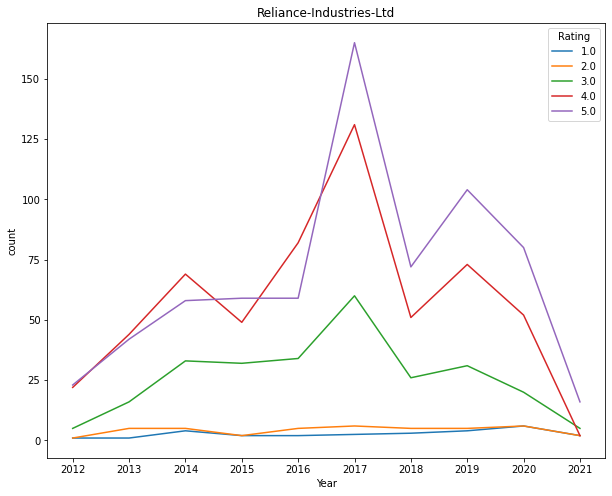

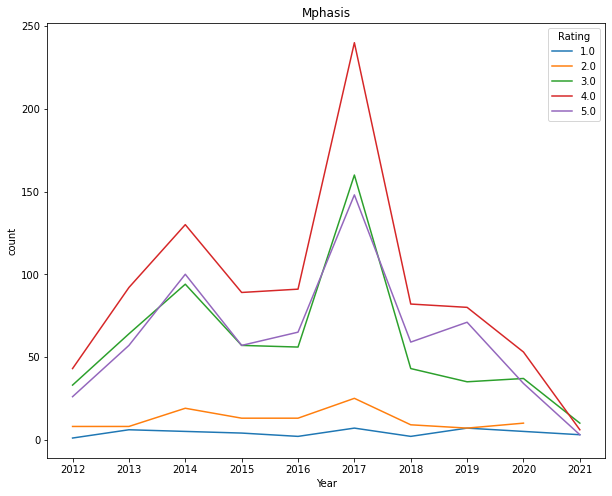

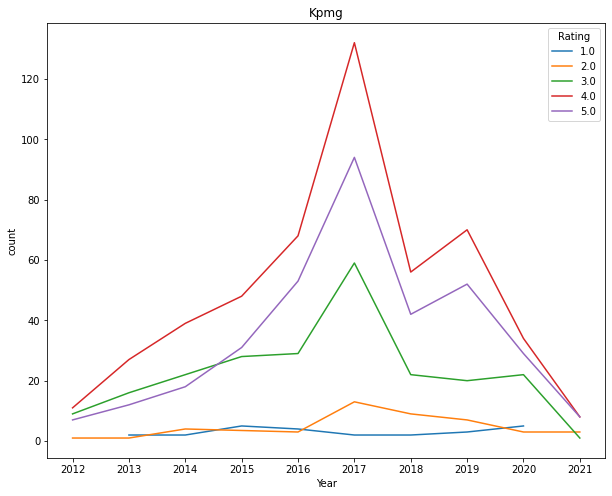

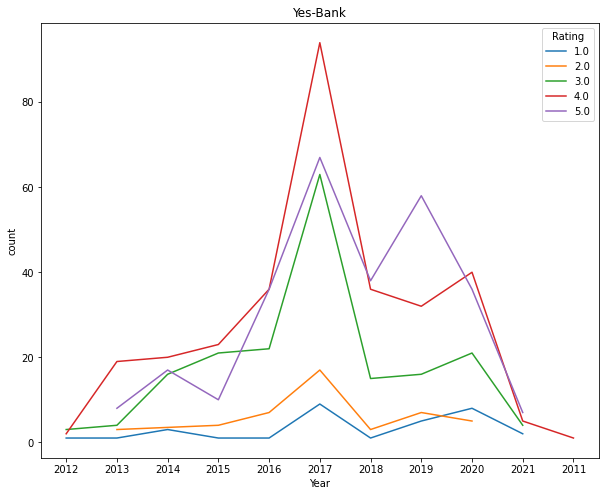

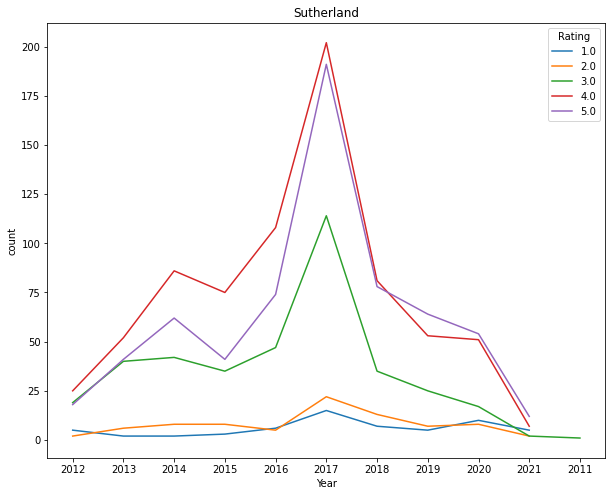

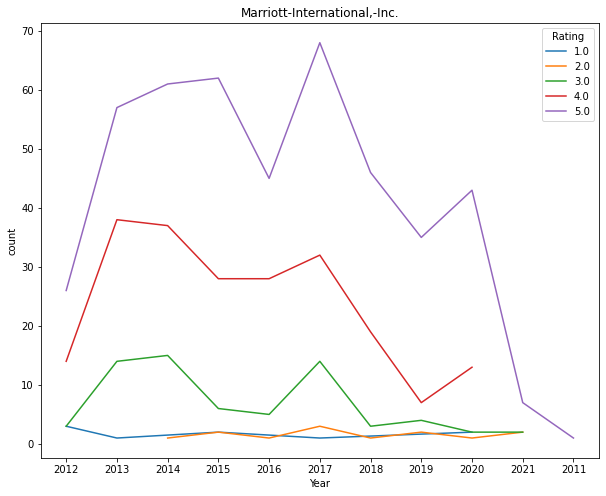

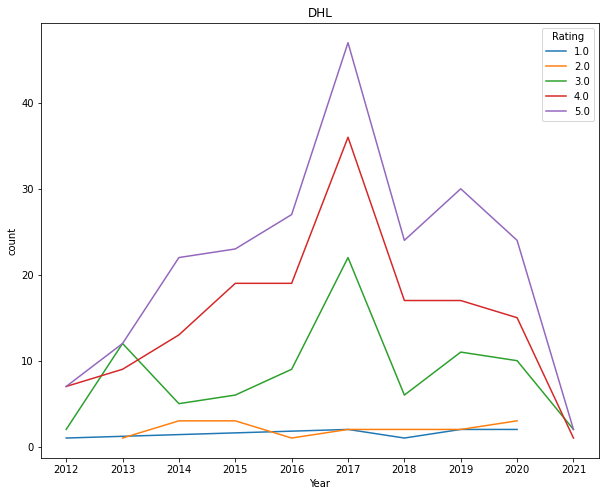

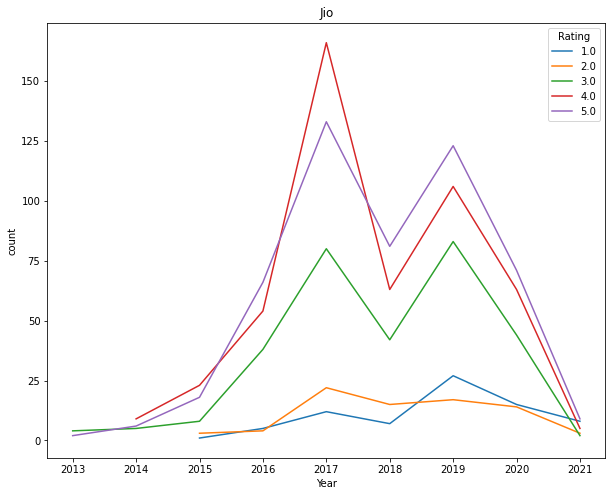

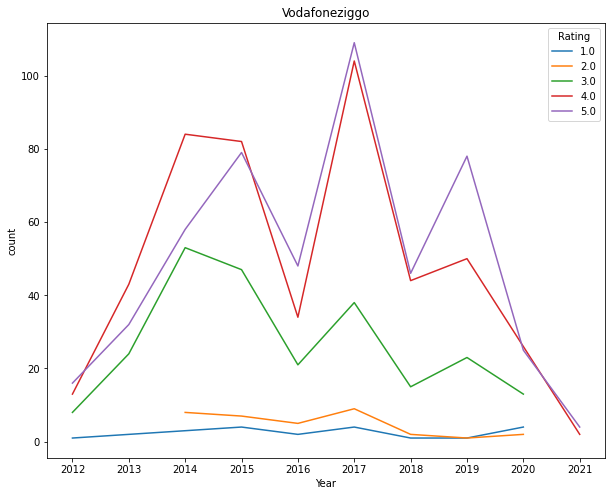

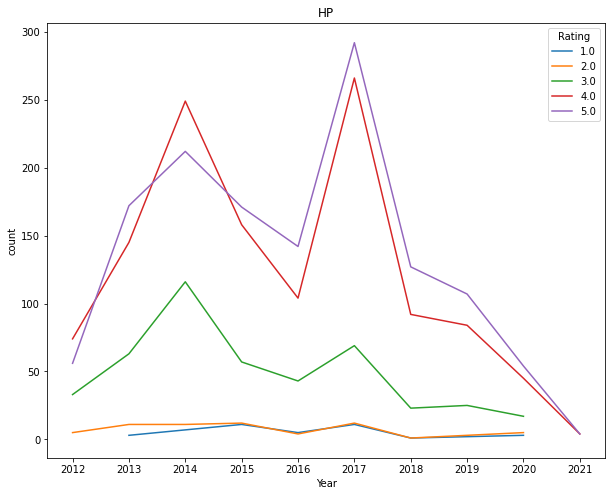

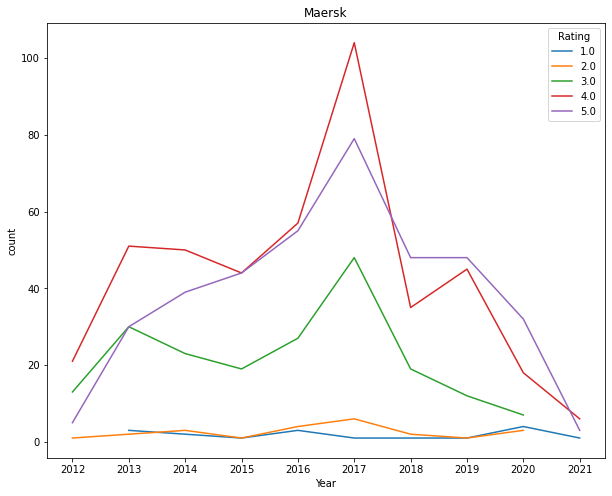

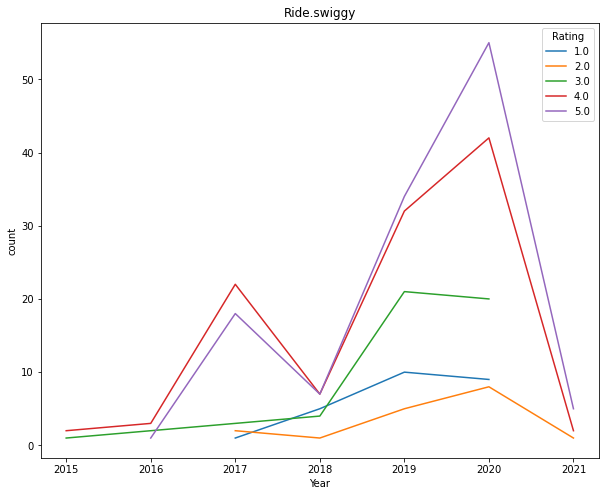

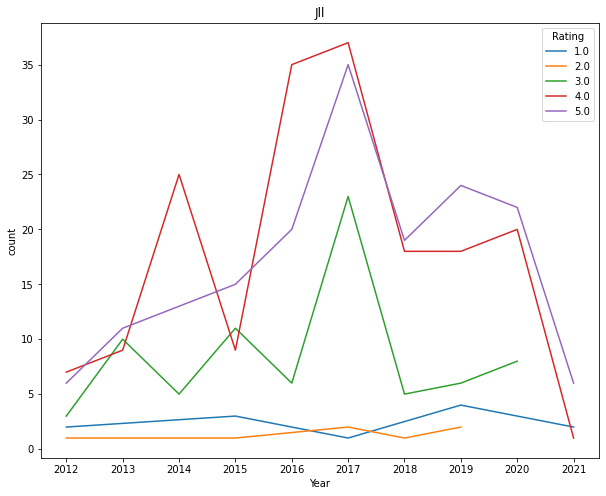

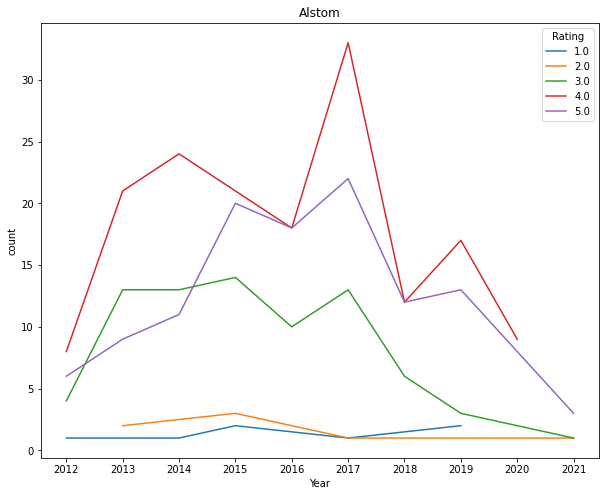

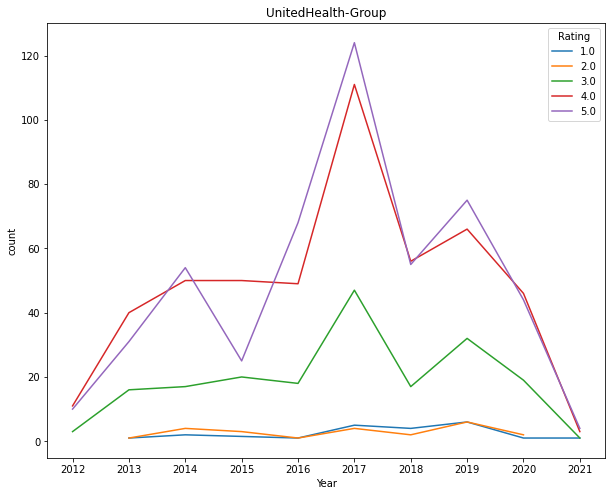

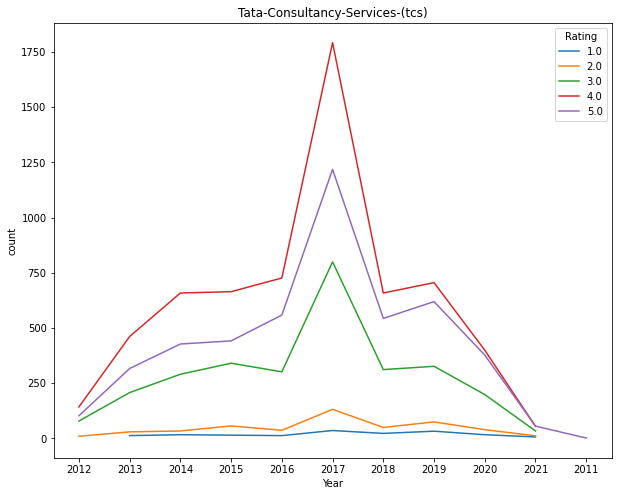

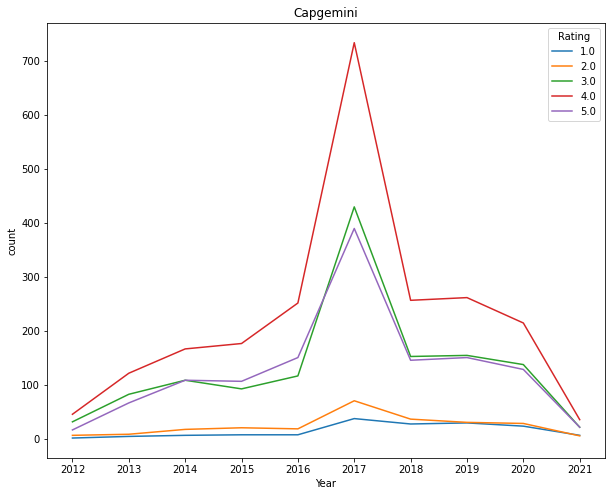

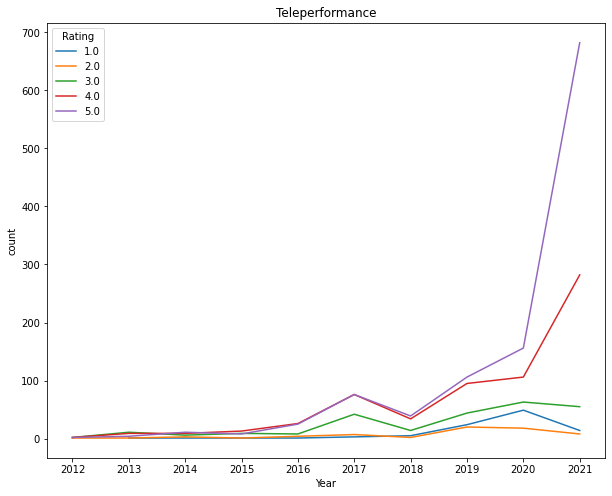

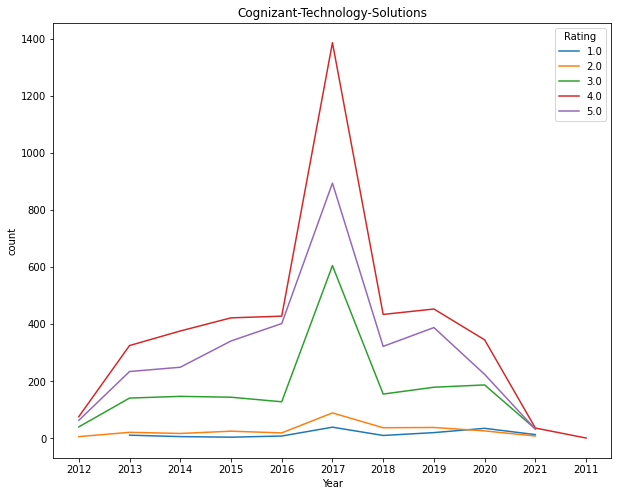

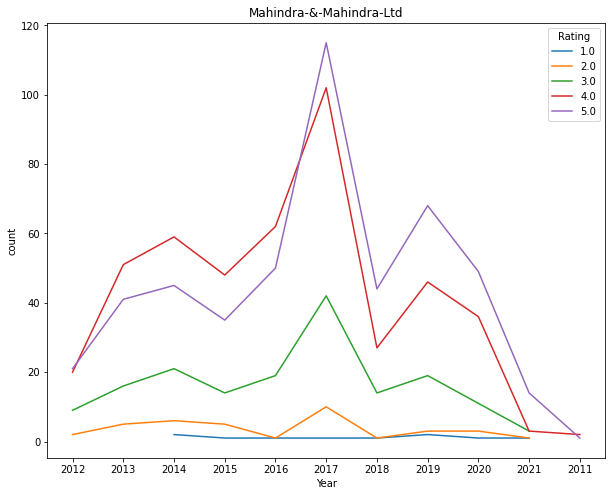

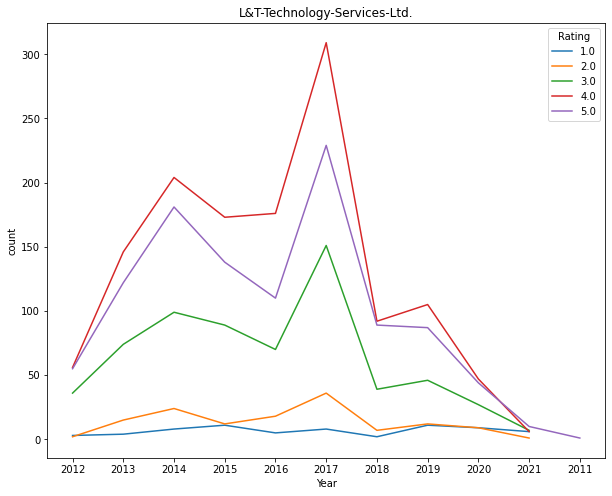

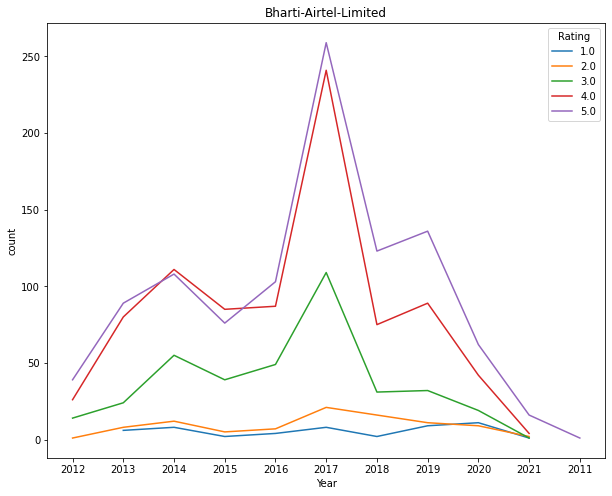

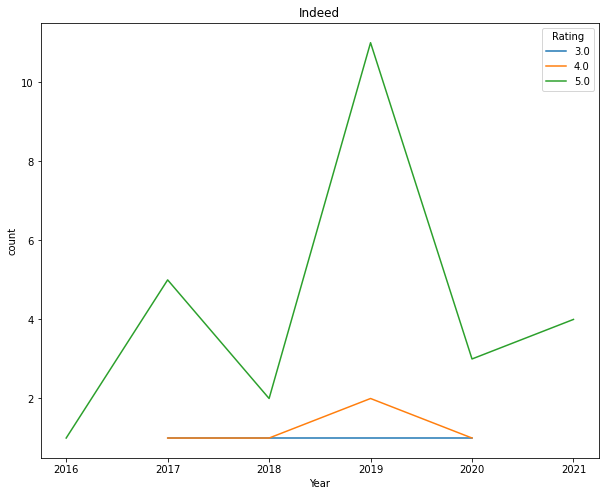

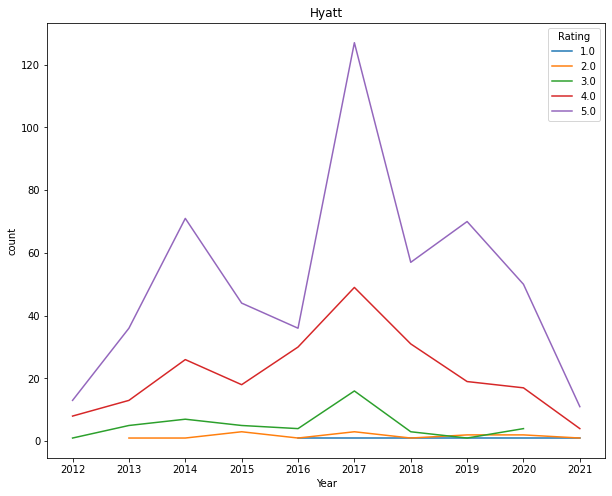

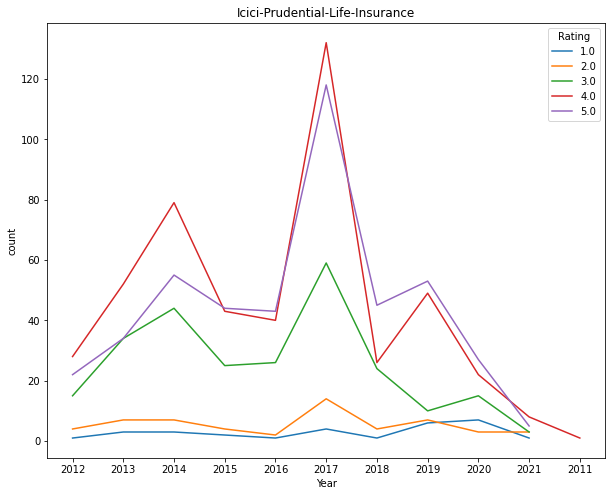

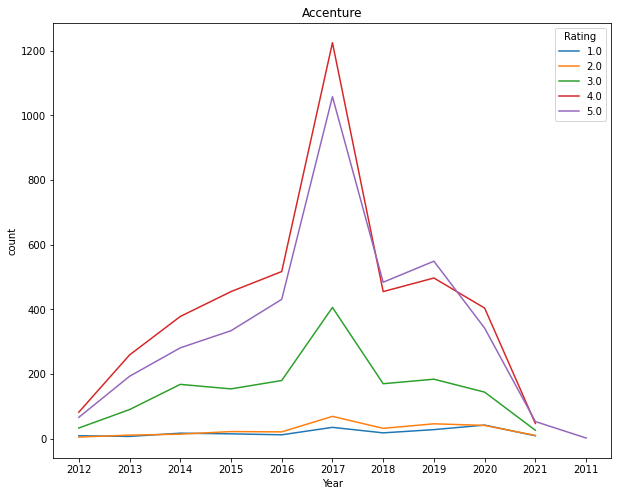

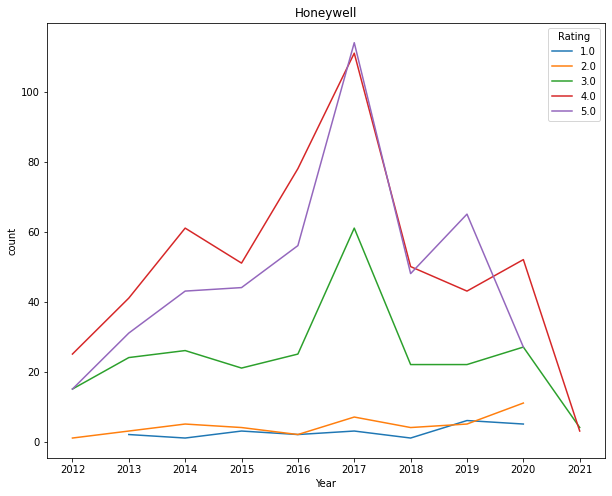

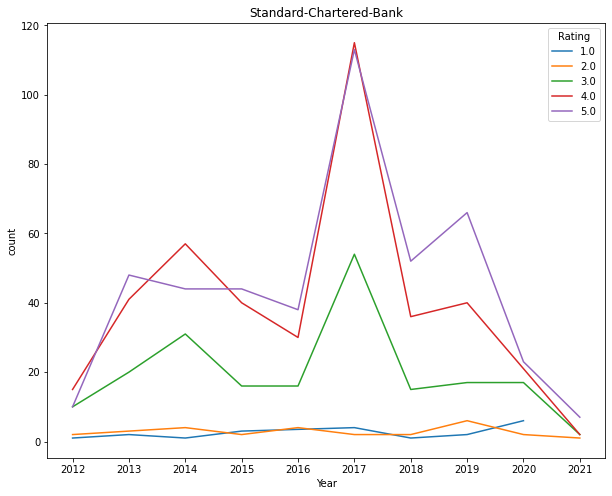

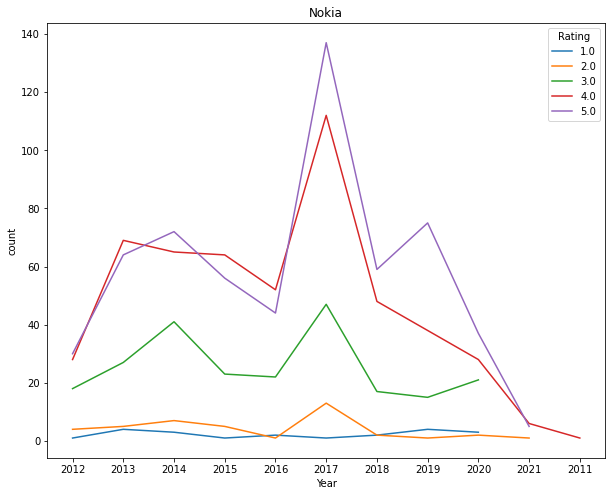

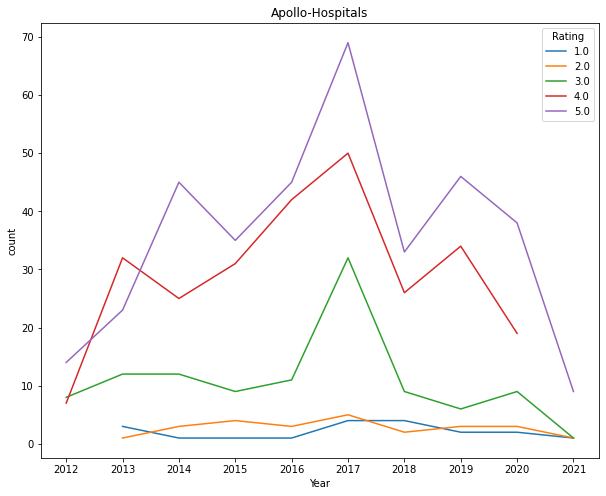

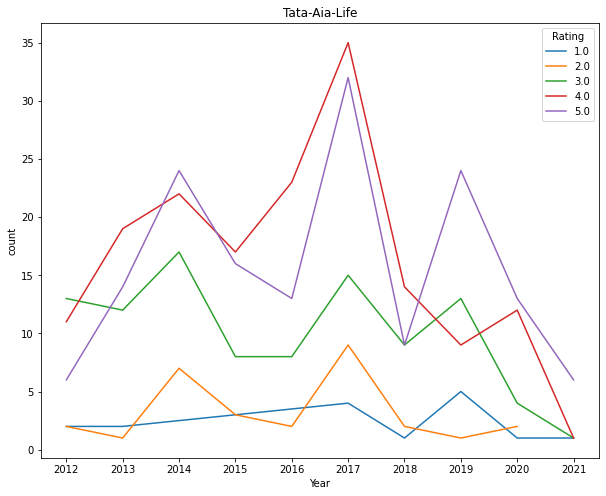

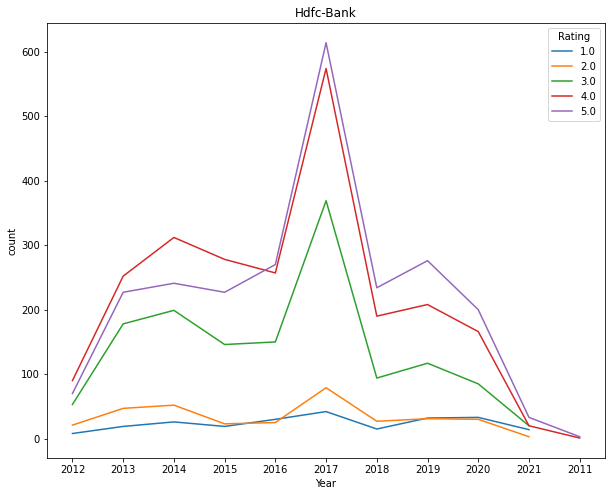

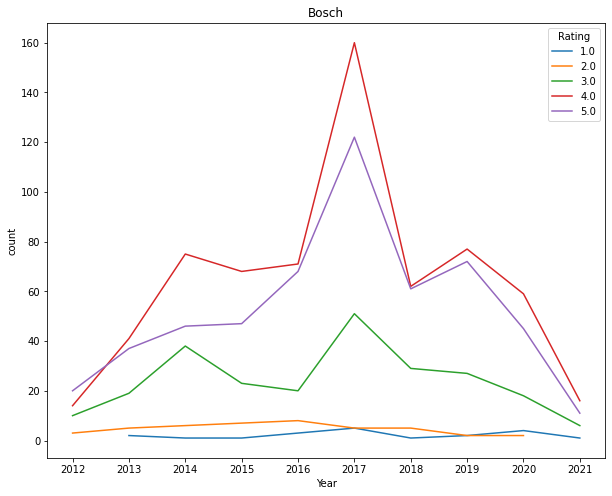

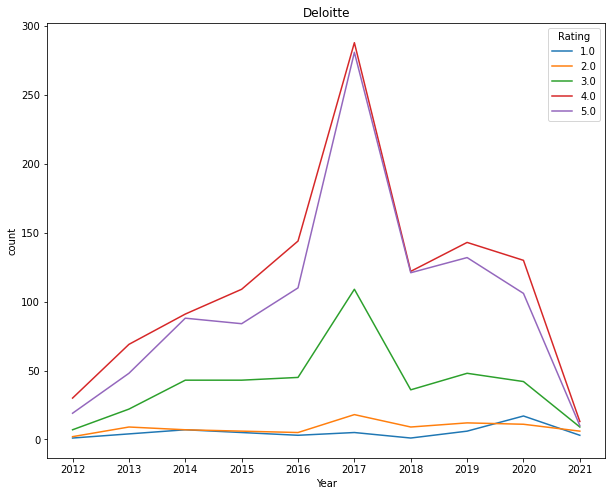

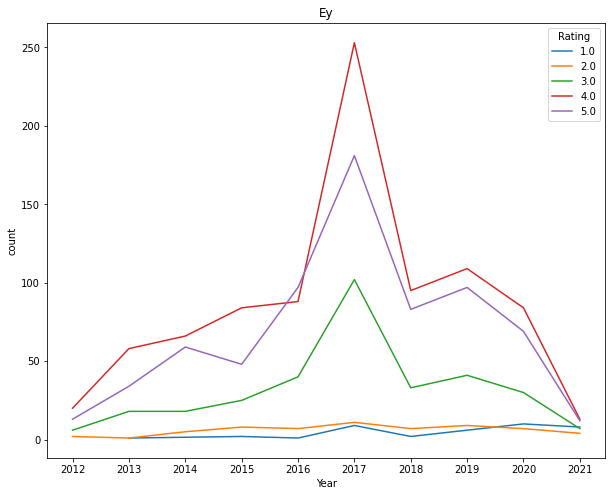

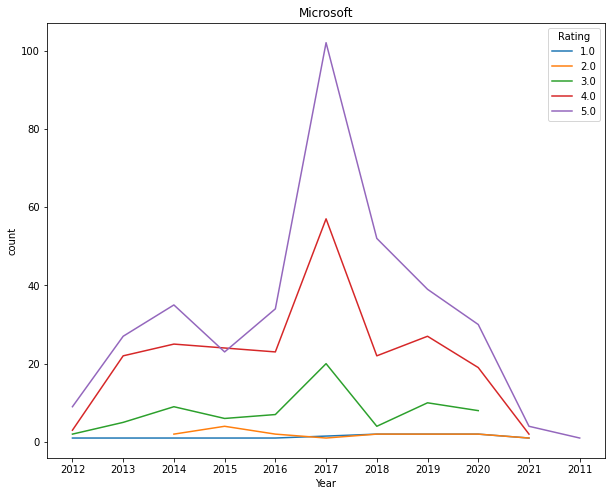

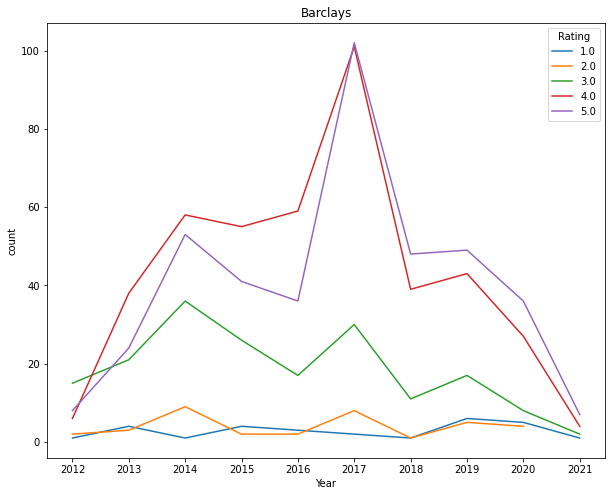

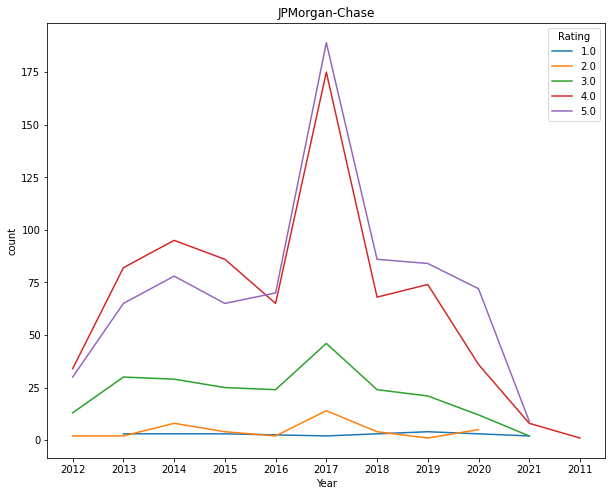

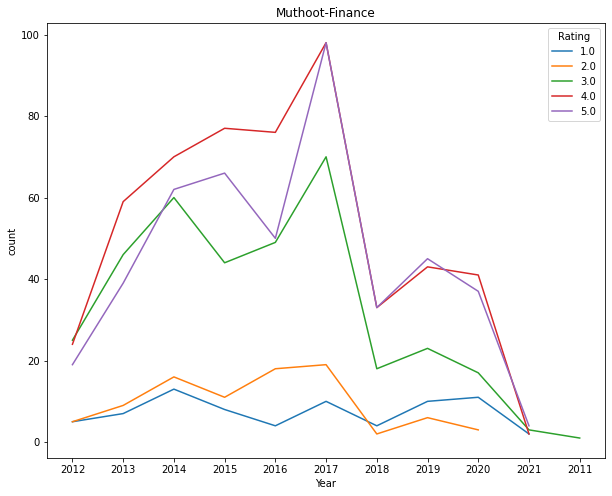

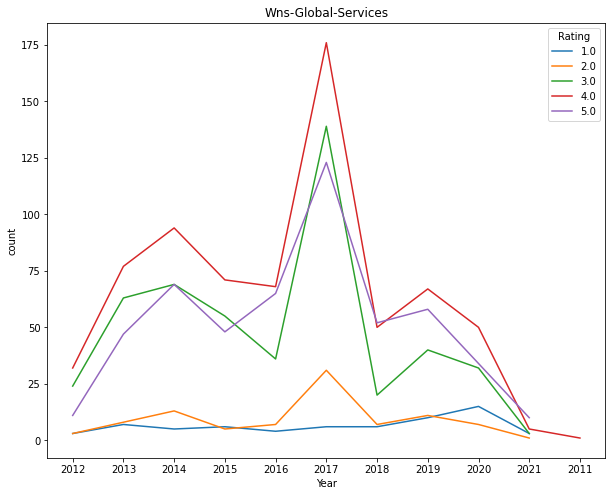

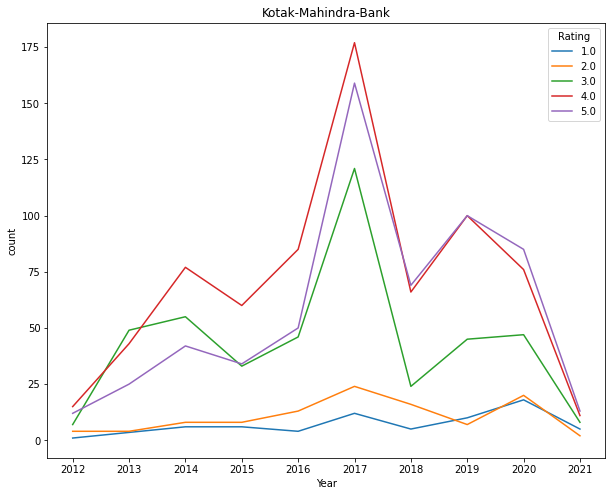

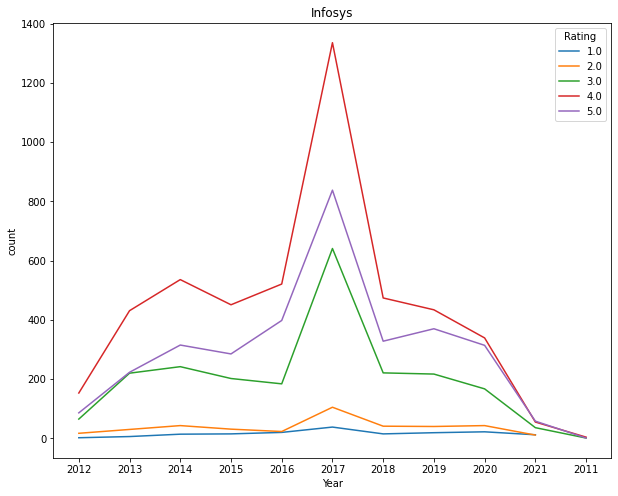

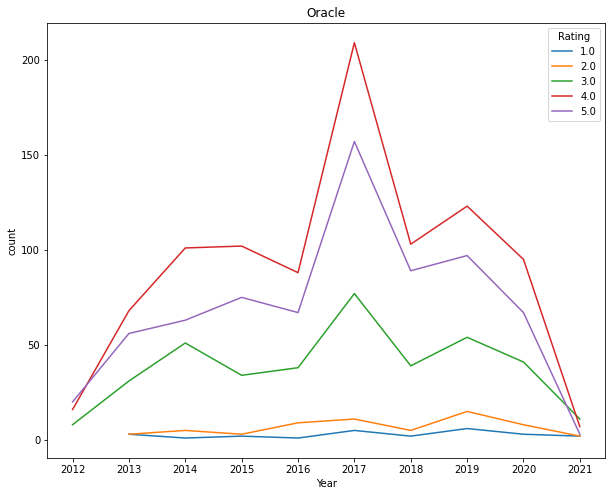

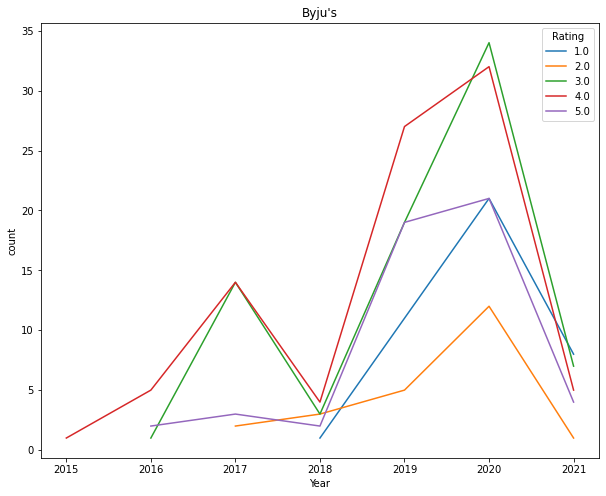

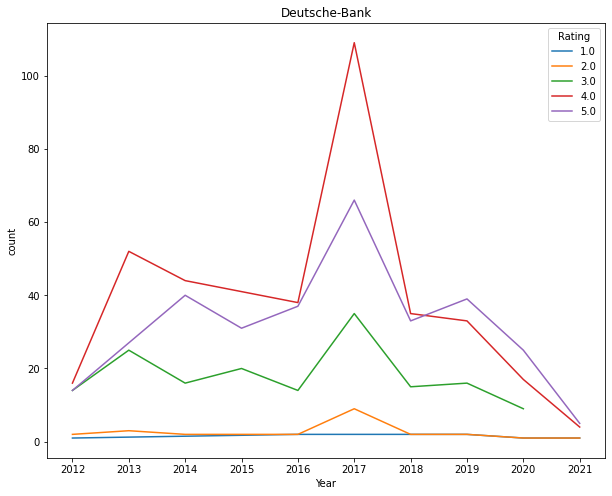

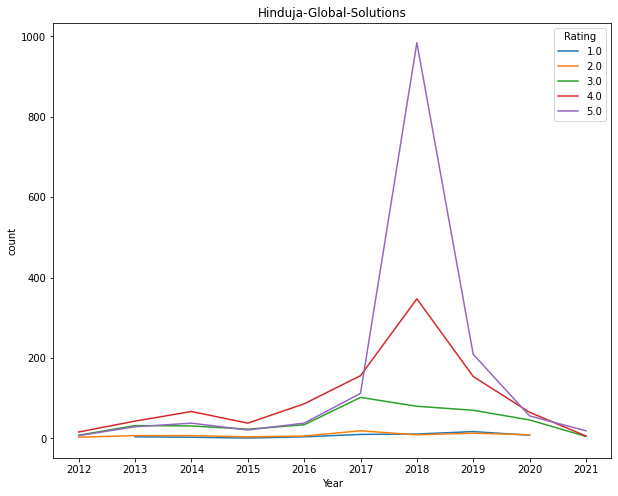

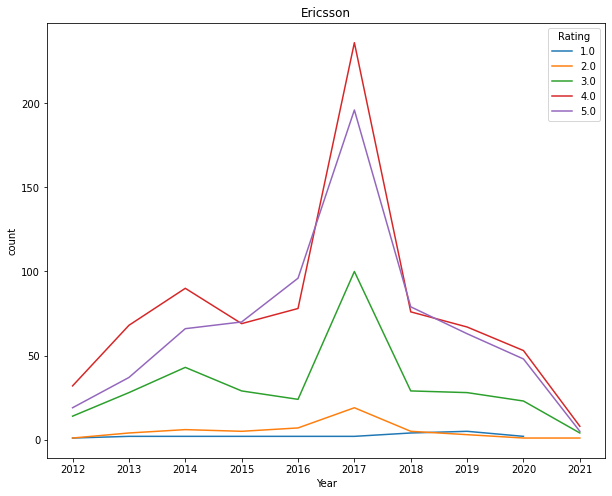

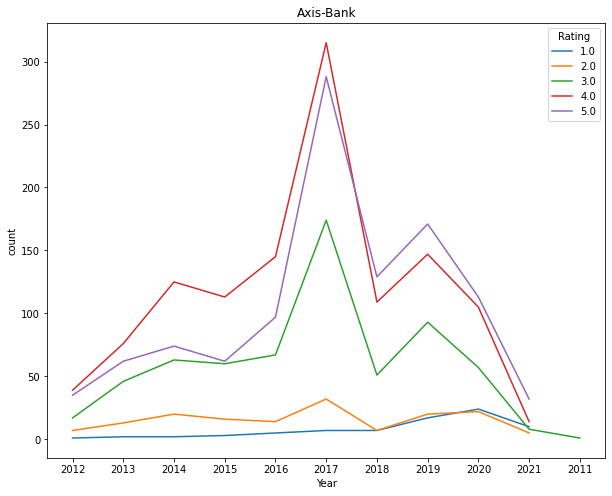

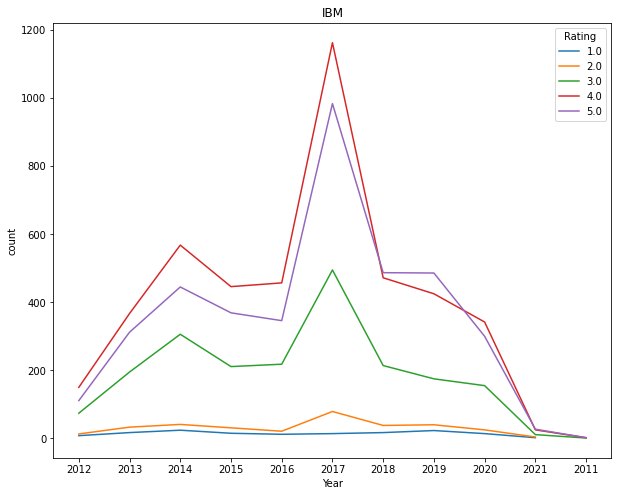

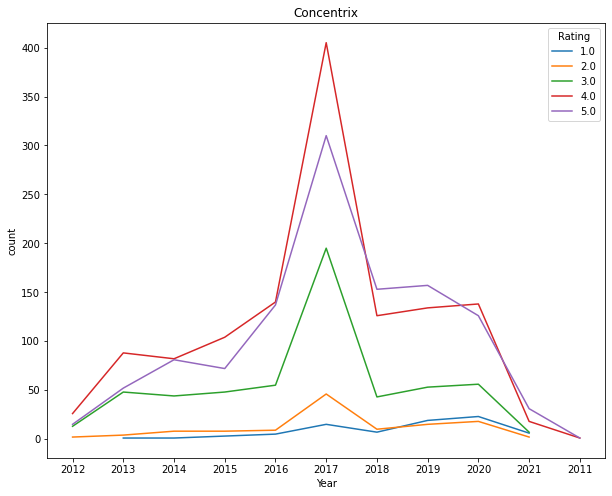

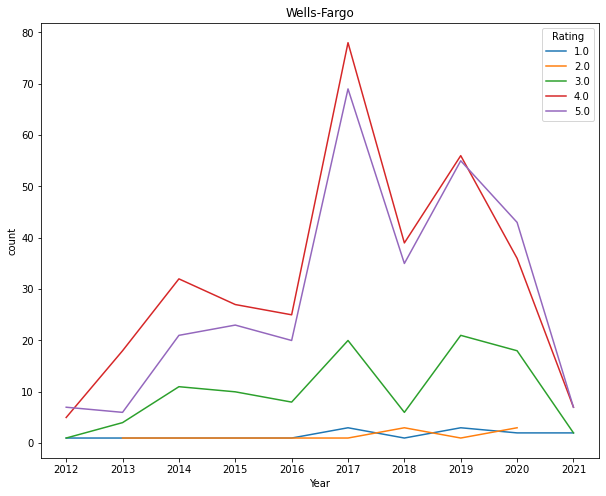

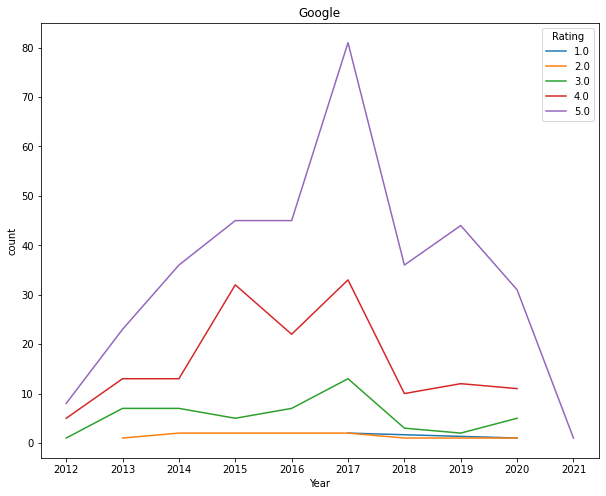

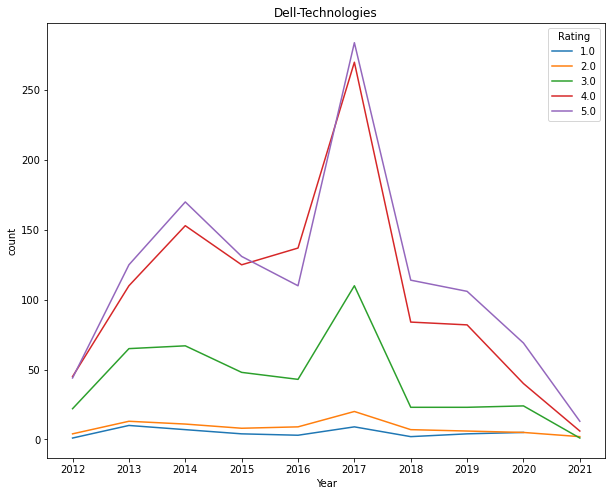

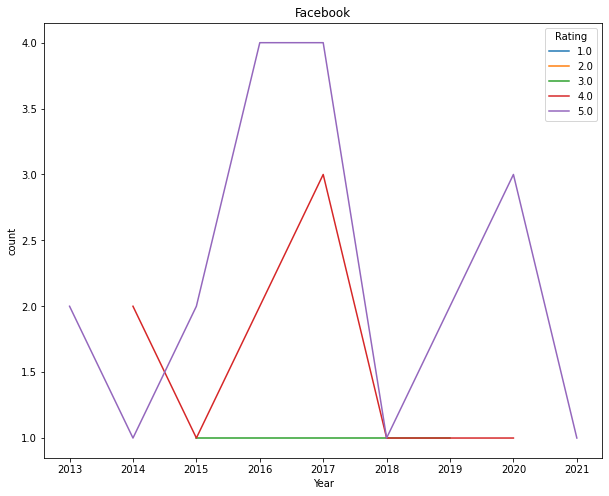

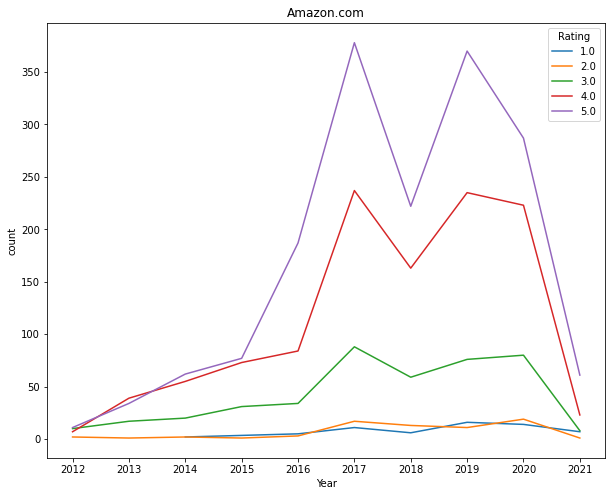

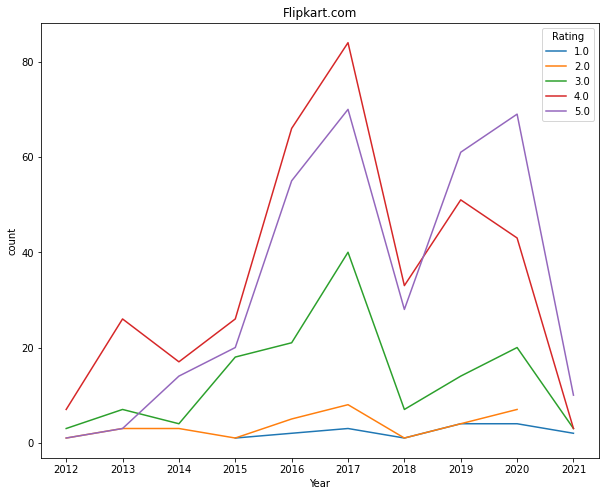

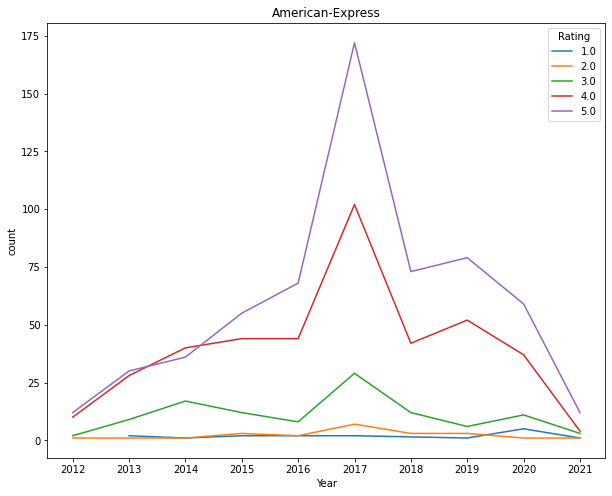

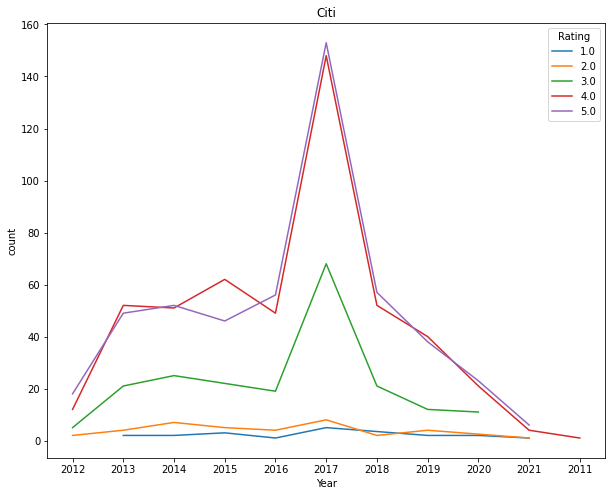

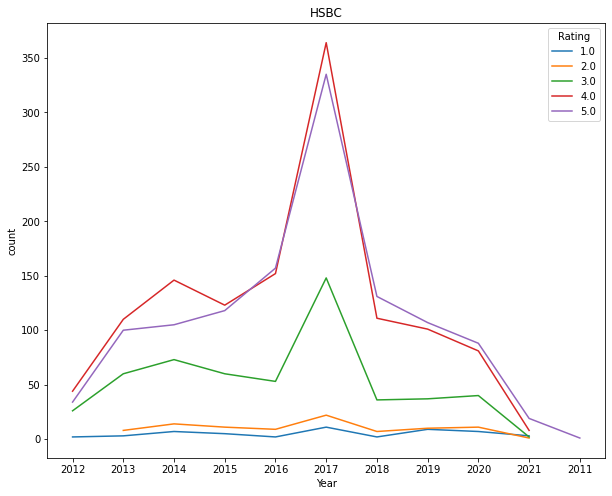

In [186]:
df_g1 = df
df_g1['Year'] = df_g1.Timestamp.astype(str).str[:4]
df_g1 = sqldf("""select Company, Rating, Year, count(*) as count from df_g1 group by Company, Rating, Year""")

for i, company_name in enumerate(list(df.Company.unique())):
  plt.figure(i)
  plt.figure(figsize = (10,8))
  sns.lineplot(x=df_g1.Year, y="count", hue="Rating", data=df_g1[df_g1['Company'] == company_name]).set_title(company_name)

**For some reason there's a spike in reviews, espacially for 5-4-3 rating stars, during the period 2017-2019**

**After 2017-2018, 4 & 5 Star reviews started to fall down for all companies.**

# Cleaning

In [ ]:
#Dropping unecessary columns
df.drop(['Company', 'EmployeeType', 'Timestamp'], axis=1, inplace=True)

In [ ]:
# Coverting 5 ratings in 3 classes

# 0    Positive  (5-4 Stars)
# 1    Neural    (2-3 Stars)
# 2    Negative  (1 Stars)

df.Rating.replace({'1.0': 3, '2.0': 2, '3.0': 2, '4.0': 1, '5.0': 1}, inplace=True)

In [ ]:
# Converting Rating field from float to int
df.Rating = df.Rating.astype(float).astype(int)

# Selecting Sample

In [ ]:
df = df.sample(frac=0.45)

# Over Sampling

In [ ]:
ros = RandomOverSampler()
X_sample, y_sample = ros.fit_resample(df[['Review']], df['Rating'])
df = pd.concat([pd.DataFrame(X_sample), pd.DataFrame(y_sample)], axis=1)

df.columns = ['Review', 'Rating']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Build, Train, Test


In [ ]:
vocab_size = 10000
sentence_length = 50
X = df.drop('Rating',axis=1)
y = df['Rating']
sentences = X.copy()

In [ ]:
# Resetting so that we don't get error during extracting process 
sentences.reset_index(inplace=True)

In [ ]:
def generate_corpus(sentences):
  ps = PorterStemmer()
  corpus = []
  for i in range(0, len(sentences)):
    review = re.sub('[^a-zA-Z]', ' ', sentences['Review'][i]).lower().split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
  return corpus

In [ ]:
def convert_ohe(corpus):
  return [one_hot(words,vocab_size) for words in corpus] 

In [ ]:
def add_padding(onehot_repr):
  return pad_sequences(onehot_repr,padding='pre',maxlen=sentence_length)

In [ ]:
# Generating corpus
corpus = generate_corpus(sentences)

In [ ]:
# Creating 
onehot_repr = convert_ohe(corpus)

In [ ]:
# Creating word embedding. 
embedded_docs = add_padding(onehot_repr)

In [ ]:
y = pd.get_dummies(df["Rating"])

In [ ]:
# LSTM Model
embedding_vector_features=80
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sentence_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64)

Epoch 1/70
1568/1568 [==============================] - 12s 7ms/step - loss: 0.6527 - accuracy: 0.6910 - val_loss: 0.4840 - val_accuracy: 0.7697
Epoch 2/70
1568/1568 [==============================] - 10s 7ms/step - loss: 0.4524 - accuracy: 0.7871 - val_loss: 0.4253 - val_accuracy: 0.7937
Epoch 3/70
1568/1568 [==============================] - 10s 7ms/step - loss: 0.3933 - accuracy: 0.8157 - val_loss: 0.3999 - val_accuracy: 0.8113
Epoch 4/70
1568/1568 [==============================] - 10s 7ms/step - loss: 0.3535 - accuracy: 0.8350 - val_loss: 0.3880 - val_accuracy: 0.8176
Epoch 5/70
1568/1568 [==============================] - 10s 7ms/step - loss: 0.3217 - accuracy: 0.8497 - val_loss: 0.3719 - val_accuracy: 0.8264
Epoch 6/70
1568/1568 [==============================] - 10s 7ms/step - loss: 0.3003 - accuracy: 0.8610 - val_loss: 0.3746 - val_accuracy: 0.8300
Epoch 7/70
1568/1568 [==============================] - 10s 7ms/step - loss: 0.2773 - accuracy: 0.8728 - val_loss: 0.3663 - val_ac

KeyboardInterrupt: ignored

In [147]:
# Saving model for future use
# model.save('model.h5')

# Evaluation Metrics

In [189]:
y_pred = model.predict(X_test)

In [190]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1))

array([[12729,  3524,   160],
       [  930, 15477,    66],
       [    0,     0, 16515]])

In [193]:
from sklearn.metrics import accuracy_score
print('Model Accuracy', accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1)))

Model Accuracy 0.905265075605757


# Making Prediction

In [143]:
data = pd.DataFrame([{'Review': 'Great place to work. Nice work culture'}, {'Review': 'Very less salary. bad work culture'}, {'Review': 'No fix working hours. Good salary hike'}])

In [144]:
corpus = generate_corpus(data)
onehot_repr = convert_ohe(corpus)
embedded_docs = add_padding(onehot_repr)
y_pred = model.predict(embedded_docs)

In [145]:
predict_text = { 0:'Positive', 1:'Neural', 2:'Negative'}

In [146]:
pd.concat([data, pd.DataFrame(np.argmax(y_pred,axis=1), columns=['Prediction']).replace(predict_text)], axis=1)

,Review,Prediction
0,Great place to work. Nice work culture,Positive
1,Very less salary. bad work culture,Negative
2,No fix working hours. Good salary hike,Neural


# Extras

In [ ]:
# model.save('model.h5')

# from keras.models import load_model
# model = load_model('model.h5')

In [148]:
#Saving corpus for future use

# with open('corpus.pkl', 'wb') as f:
#   pickle.dump(corpus, f)

# with open('corpus.pkl', 'rb') as f:
#   corpus = pickle.load(f)